In [250]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Read data
df = pd.read_csv("unlabeled_data.csv")  # Replace with your CSV file name

# Select only the relevant columns
feature_cols = ["Earnings_Surprise", "Firm_Size", "method_2"]
target_cols = ["CAR_3_Days", "CAR_10_Days", "CAR_30_Days"]
df = df[feature_cols + target_cols]  # Keep only selected columns

### 1️⃣ Handling Missing Values ###
# If missing values are less than 20%, fill them with the mean; otherwise, drop the row
missing_threshold = 0.2  # Maximum allowed missing ratio per row
df = df.dropna(thresh=int(len(df.columns) * missing_threshold))  # Drop rows with excessive missing values
df = df.fillna(df.mean())  # Fill remaining missing values with mean

### 2️⃣ Standardization ###
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

### 3️⃣ Outlier Handling ###
# Using the IQR method
Q1 = df[feature_cols].quantile(0.25)
Q3 = df[feature_cols].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df = df[~((df[feature_cols] < lower_bound) | (df[feature_cols] > upper_bound)).any(axis=1)]

# Using the Z-score method for further outlier detection
from scipy.stats import zscore
z_scores = np.abs(zscore(df[feature_cols]))
df = df[(z_scores < 3).all(axis=1)]  # Remove rows where any feature has a Z-score > 3

# Keep only the relevant columns
df = df[feature_cols + target_cols]

print(df.head())


   Earnings_Surprise  Firm_Size  method_2  CAR_3_Days  CAR_10_Days  \
0          -0.015581  -0.208570  1.766057   -0.014271     0.010221   
1          -0.023933  -0.338141  0.071589   -0.008348    -0.026677   
2          -0.009249  -0.339219  0.282063    0.094707     0.089449   
4          -0.028122  -0.322995 -1.021321    0.017126     0.026210   
5          -0.024730  -0.124929  0.153801   -0.021278     0.016655   

   CAR_30_Days  
0     0.083406  
1    -0.059266  
2     0.049796  
4    -0.054972  
5    -0.013365  


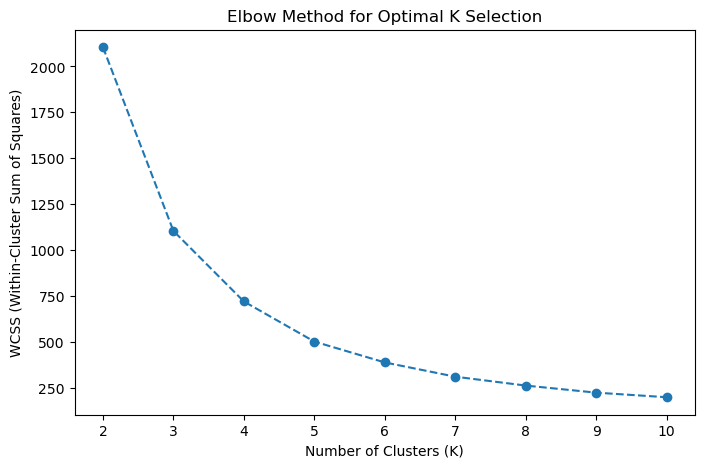

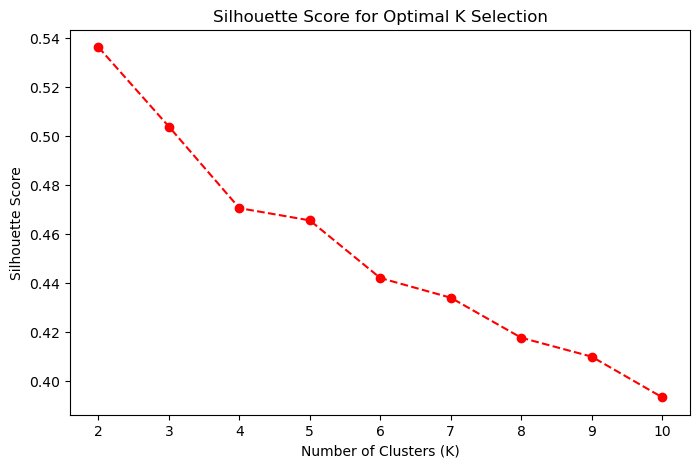

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = df[feature_cols]

### 1️⃣ Using the Elbow Method to Identify the Optimal K ###
wcss = []  # Store Within-Cluster Sum of Squares (WCSS) for each K
K_range = range(2, 11)  # Test cluster counts from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # Record WCSS (sum of squared errors)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker="o", linestyle="--")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K Selection")
plt.show()

### 2️⃣ Calculating Silhouette Score to Assist K Selection ###
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, labels))

# Plot the Silhouette Score graph
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker="o", linestyle="--", color="r")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal K Selection")
plt.show()

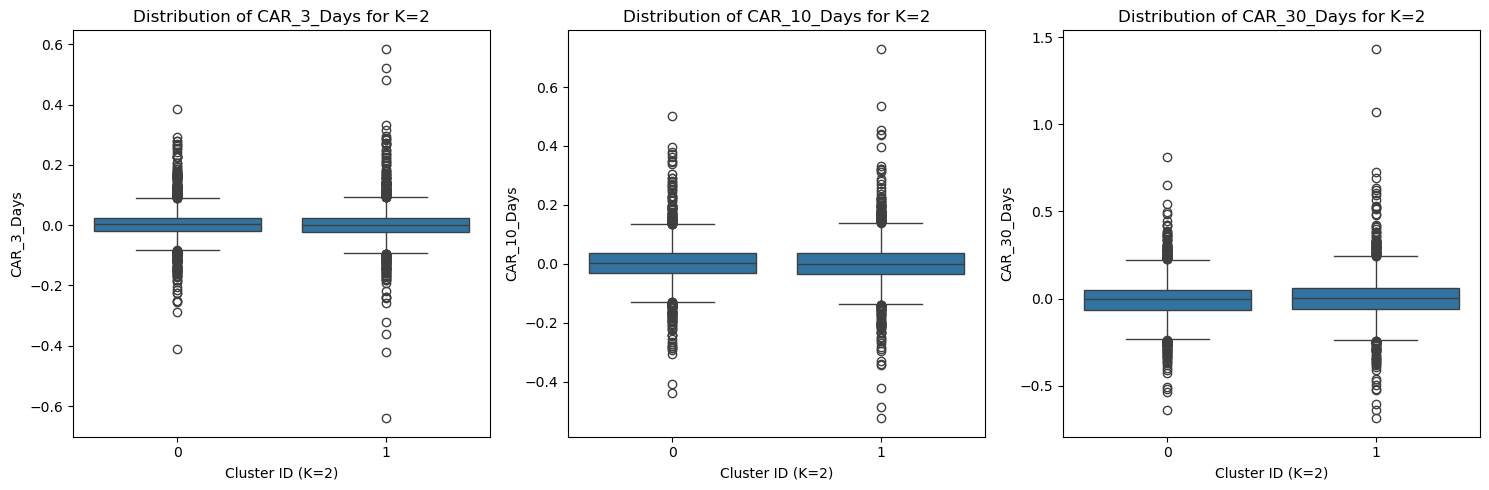

📊 Mean CAR values for K=2:
           CAR_3_Days  CAR_10_Days  CAR_30_Days
Cluster_2                                      
0            0.003940     0.003167    -0.002711
1            0.001729     0.002503     0.006340
--------------------------------------------------


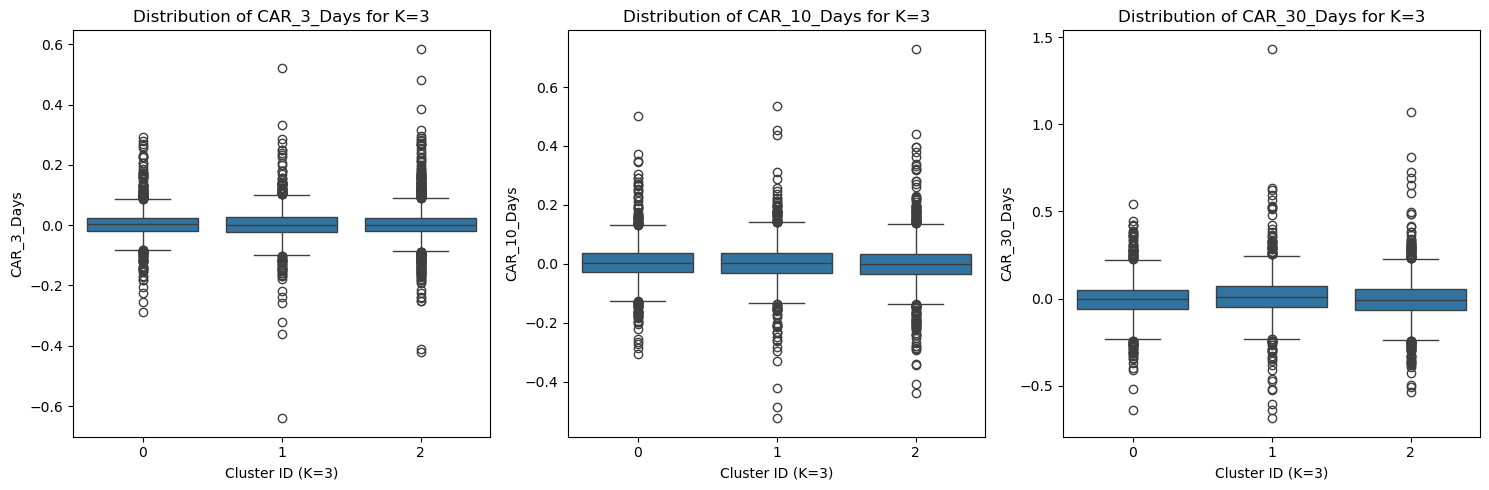

📊 Mean CAR values for K=3:
           CAR_3_Days  CAR_10_Days  CAR_30_Days
Cluster_3                                      
0            0.004474     0.004366    -0.001822
1            0.001606     0.004537     0.012960
2            0.002522     0.000846    -0.002512
--------------------------------------------------


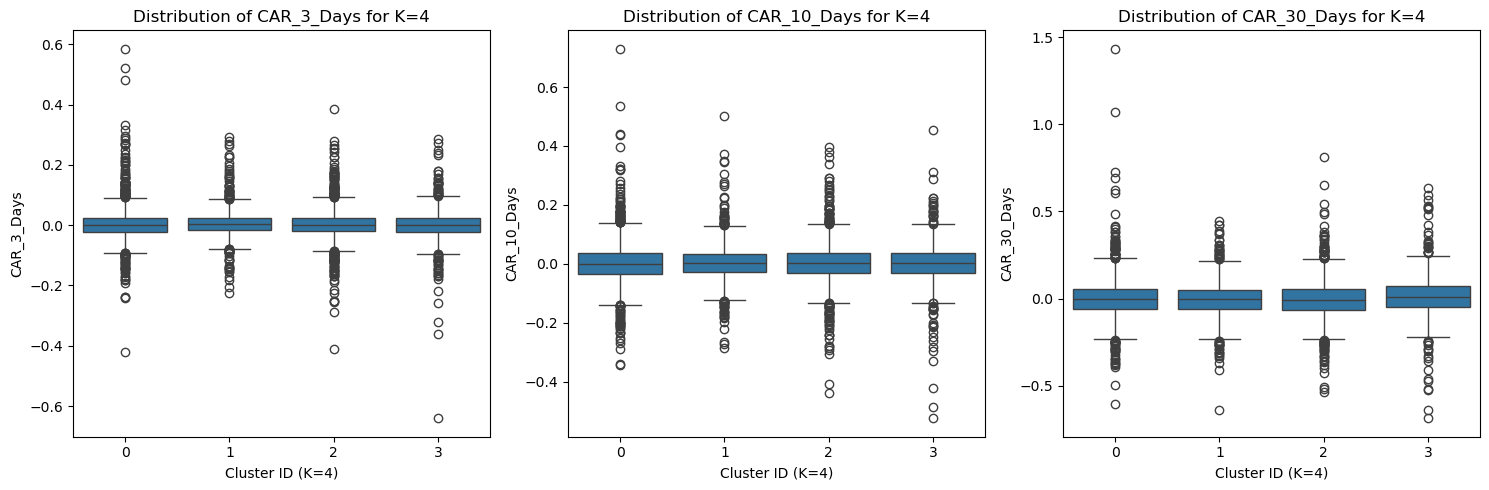

📊 Mean CAR values for K=4:
           CAR_3_Days  CAR_10_Days  CAR_30_Days
Cluster_4                                      
0            0.002783     0.002770     0.002888
1            0.005408     0.004600    -0.002547
2            0.002956     0.002349    -0.002856
3           -0.000035     0.001954     0.013097
--------------------------------------------------


In [252]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

X = df[feature_cols]

# Perform clustering for K=2, K=3, and K=4
k_values = [2, 3, 4]
clustered_dfs = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    df[f"Cluster_{k}"] = kmeans.fit_predict(X)
    clustered_dfs[k] = df.copy()  # Save results for each K
    
for k in k_values:
    df_k = clustered_dfs[k]

    plt.figure(figsize=(15, 5))
    for i, col in enumerate(target_cols):
        plt.subplot(1, 3, i+1)
        sns.boxplot(x=df_k[f"Cluster_{k}"], y=df_k[col])
        plt.xlabel(f"Cluster ID (K={k})")
        plt.ylabel(col)
        plt.title(f"Distribution of {col} for K={k}")

    plt.tight_layout()
    plt.show()

    # Calculate the mean CAR values for each cluster
    print(f"📊 Mean CAR values for K={k}:")
    print(df_k.groupby(f"Cluster_{k}")[target_cols].mean())
    print("-" * 50)

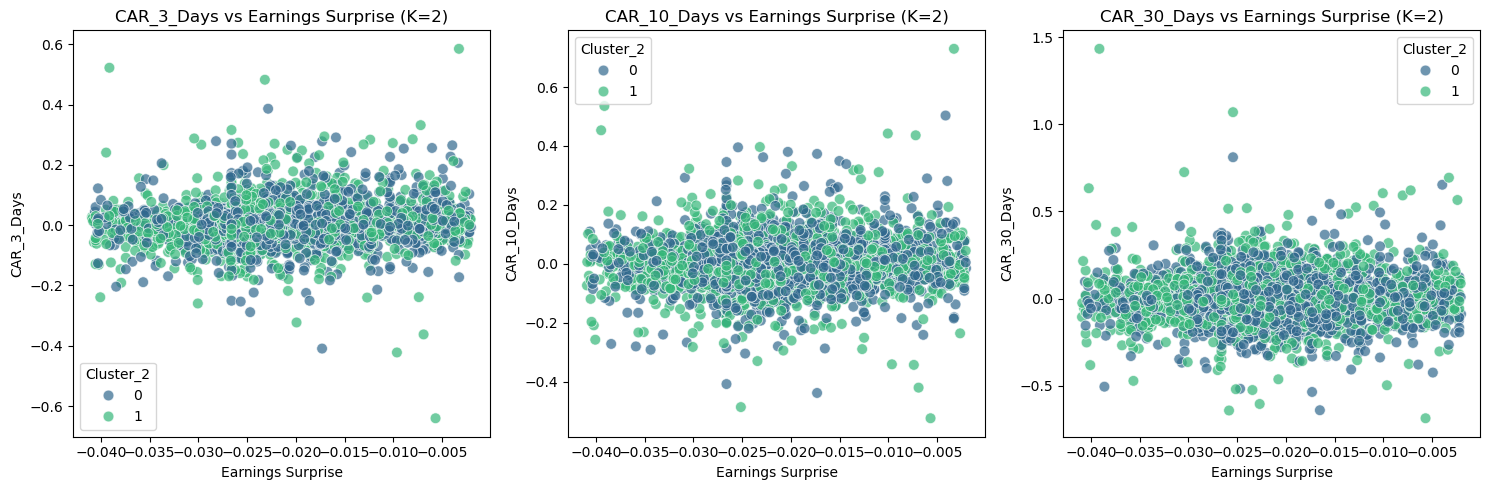

📊 Mean CAR values for K=2:
           CAR_3_Days  CAR_10_Days  CAR_30_Days
Cluster_2                                      
0            0.003940     0.003167    -0.002711
1            0.001729     0.002503     0.006340
--------------------------------------------------


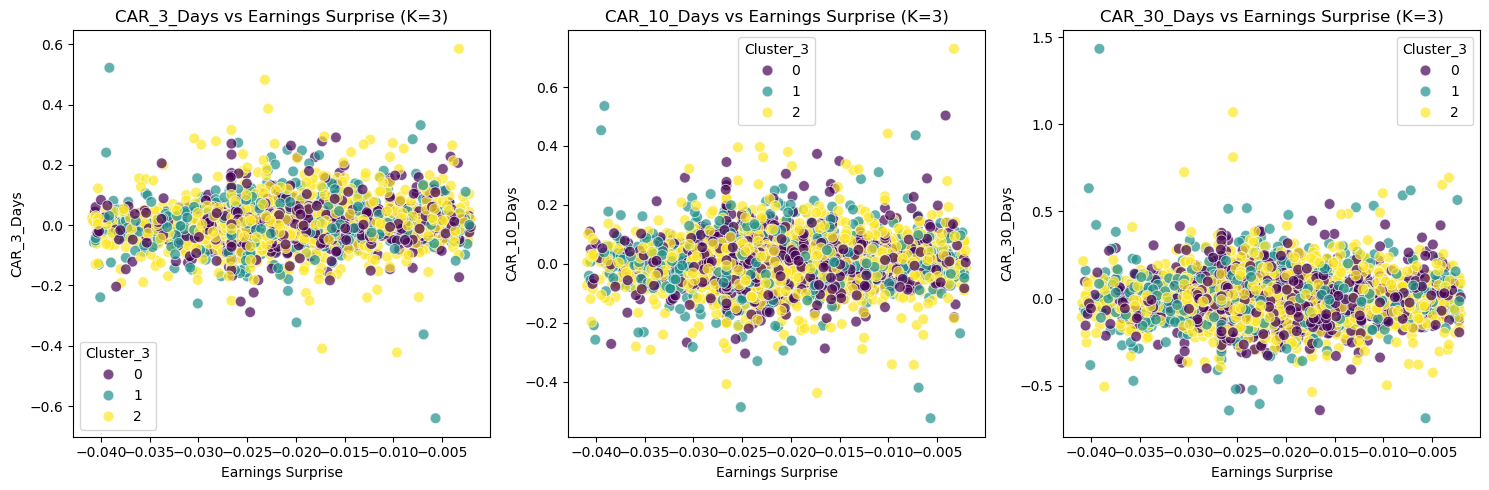

📊 Mean CAR values for K=3:
           CAR_3_Days  CAR_10_Days  CAR_30_Days
Cluster_3                                      
0            0.004474     0.004366    -0.001822
1            0.001606     0.004537     0.012960
2            0.002522     0.000846    -0.002512
--------------------------------------------------


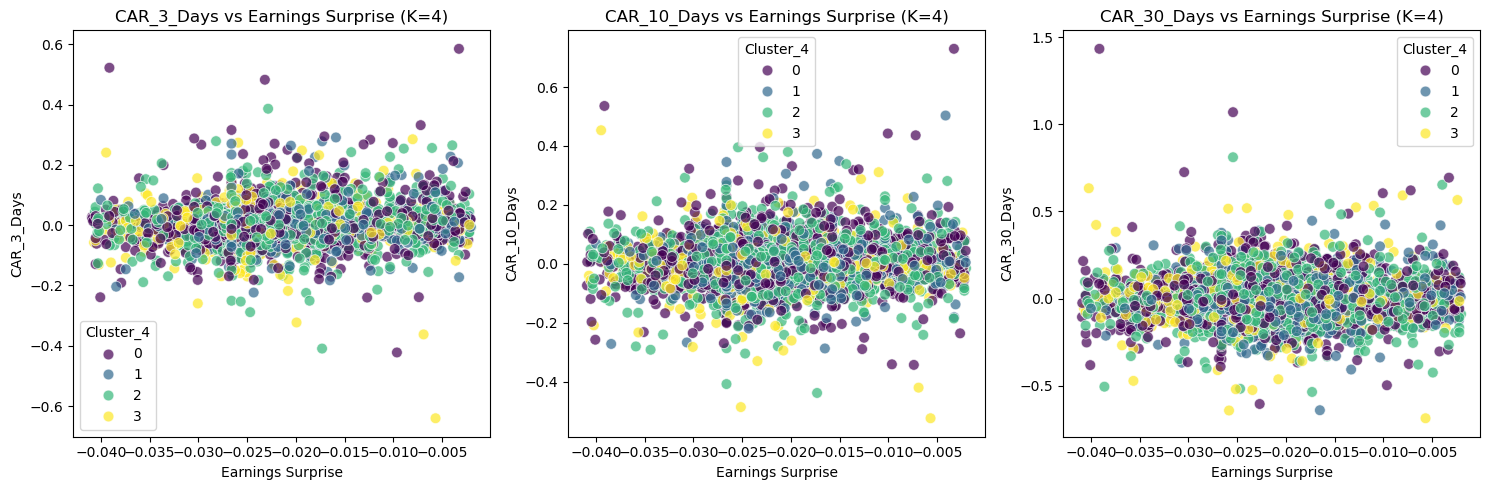

📊 Mean CAR values for K=4:
           CAR_3_Days  CAR_10_Days  CAR_30_Days
Cluster_4                                      
0            0.002783     0.002770     0.002888
1            0.005408     0.004600    -0.002547
2            0.002956     0.002349    -0.002856
3           -0.000035     0.001954     0.013097
--------------------------------------------------


In [253]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


# Select feature columns for clustering
feature_cols = ["Earnings_Surprise", "Firm_Size", "method_2"]
X = df[feature_cols]

# Perform clustering for K=2, K=3, and K=4
k_values = [2, 3, 4]
clustered_dfs = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    df[f"Cluster_{k}"] = kmeans.fit_predict(X)
    clustered_dfs[k] = df.copy()  # Save results for each K

# Define target columns for visualization
target_cols = ["CAR_3_Days", "CAR_10_Days", "CAR_30_Days"]

df[target_cols] = scaler.fit_transform(df[target_cols])

# Scatter plots with different colors for each cluster
for k in k_values:
    df_k = clustered_dfs[k]
    
    plt.figure(figsize=(15, 5))
    
    for i, col in enumerate(target_cols):
        plt.subplot(1, 3, i + 1)
        sns.scatterplot(x=df_k["Earnings_Surprise"], y=df_k[col], hue=df_k[f"Cluster_{k}"], palette="viridis", s=60, alpha=0.7)
        plt.xlabel("Earnings Surprise")
        plt.ylabel(col)
        plt.title(f"{col} vs Earnings Surprise (K={k})")

    plt.tight_layout()
    plt.show()

    print(f"📊 Mean CAR values for K={k}:")
    print(df_k.groupby(f"Cluster_{k}")[target_cols].mean())
    print("-" * 50)


In [254]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

# Read data
df = pd.read_csv("unlabeled_data.csv")  # Replace with your CSV file name

df_original = df.copy()

# Store the Earnings_Call_Date column separately
if "Earnings_Call_Date" in df.columns:
    earnings_call_date = df["Earnings_Call_Date"]
    df = df.drop(columns=["Earnings_Call_Date"])  # Temporarily remove it
else:
    earnings_call_date = None  # Handle case where column might not exist

# Select only the relevant columns for preprocessing
feature_cols = ["Earnings_Surprise", "Firm_Size", "method_2"]
target_cols = ["CAR_3_Days", "CAR_10_Days", "CAR_30_Days"]
df = df[feature_cols + target_cols]  # Keep only selected columns

### 1️⃣ Handling Missing Values ###
# If missing values are less than 20%, fill them with the mean; otherwise, drop the row
missing_threshold = 0.2  # Maximum allowed missing ratio per row
df = df.dropna(thresh=int(len(df.columns) * missing_threshold))  # Drop rows with excessive missing values
df = df.fillna(df.mean())  # Fill remaining missing values with mean

### 2️⃣ Standardization ###
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

### 3️⃣ Outlier Handling ###
# Using the IQR method
Q1 = df[feature_cols].quantile(0.25)
Q3 = df[feature_cols].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df = df[~((df[feature_cols] < lower_bound) | (df[feature_cols] > upper_bound)).any(axis=1)]

# Using the Z-score method for further outlier detection
z_scores = np.abs(zscore(df[feature_cols]))
df = df[(z_scores < 3).all(axis=1)]  # Remove rows where any feature has a Z-score > 3

# Reattach the Earnings_Call_Date column
if earnings_call_date is not None:
    df["Earnings_Call_Date"] = earnings_call_date.loc[df.index]  # Ensure alignment

# Keep only the relevant columns
df = df[["Earnings_Call_Date"] + feature_cols + target_cols]  # Ensure the order

print(df.head())

# Remove instances in original_df that are NOT in df
df_original = df_original[df_original[target_cols].apply(tuple, axis=1).isin(df[target_cols].apply(tuple, axis=1))]

  Earnings_Call_Date  Earnings_Surprise  Firm_Size  method_2  CAR_3_Days  \
0         2020-01-08          -0.015581  -0.208570  1.766057   -0.014271   
1         2020-01-08          -0.023933  -0.338141  0.071589   -0.008348   
2         2020-01-22          -0.009249  -0.339219  0.282063    0.094707   
4         2020-01-23          -0.028122  -0.322995 -1.021321    0.017126   
5         2020-01-24          -0.024730  -0.124929  0.153801   -0.021278   

   CAR_10_Days  CAR_30_Days  
0     0.010221     0.083406  
1    -0.026677    -0.059266  
2     0.089449     0.049796  
4     0.026210    -0.054972  
5     0.016655    -0.013365  


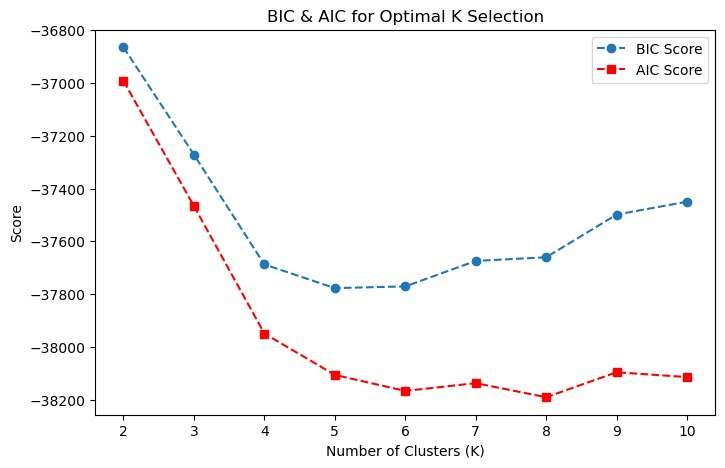

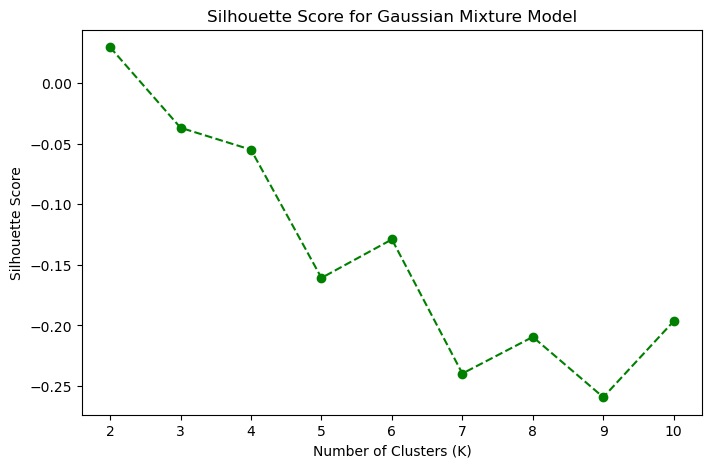

Check the graphs above and manually select the best K in the next step.


In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

X = df[feature_cols]

### 1️⃣ Using the Elbow Method with Gaussian Mixture Model (BIC and AIC for Optimal K) ###
bic_scores = []  # Bayesian Information Criterion (BIC)
aic_scores = []  # Akaike Information Criterion (AIC)
K_range = range(2, 11)  # Test cluster counts from 2 to 10

for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    gmm.fit(X)
    bic_scores.append(gmm.bic(X))  # BIC Score
    aic_scores.append(gmm.aic(X))  # AIC Score

# Plot BIC and AIC Scores to Find Optimal K
plt.figure(figsize=(8, 5))
plt.plot(K_range, bic_scores, marker="o", linestyle="--", label="BIC Score")
plt.plot(K_range, aic_scores, marker="s", linestyle="--", label="AIC Score", color="r")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Score")
plt.title("BIC & AIC for Optimal K Selection")
plt.legend()
plt.show()

### 2️⃣ Calculating Silhouette Score for Gaussian Mixture Model ###
silhouette_scores = []

for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    labels = gmm.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, labels))

# Plot the Silhouette Score graph
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker="o", linestyle="--", color="g")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Gaussian Mixture Model")
plt.show()

print("Check the graphs above and manually select the best K in the next step.")


Silhouette Score for K=3: -0.0369


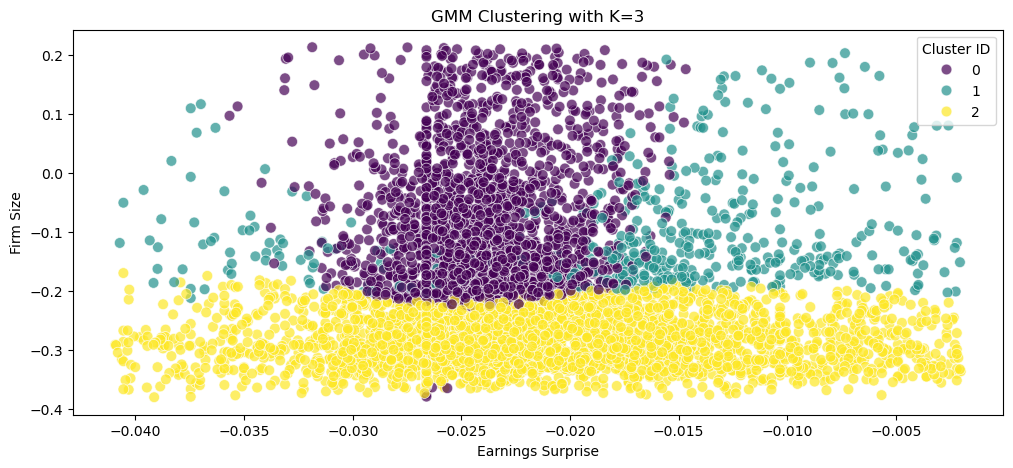

<Figure size 1200x400 with 0 Axes>

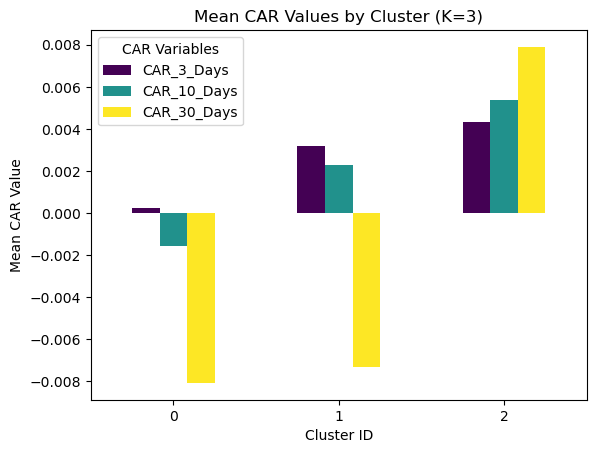

📊 Mean CAR values for K=3:
           CAR_3_Days  CAR_10_Days  CAR_30_Days
Cluster_3                                      
0            0.000261    -0.001544    -0.008078
1            0.003189     0.002297    -0.007319
2            0.004334     0.005350     0.007897
--------------------------------------------------
Silhouette Score for K=4: -0.0551


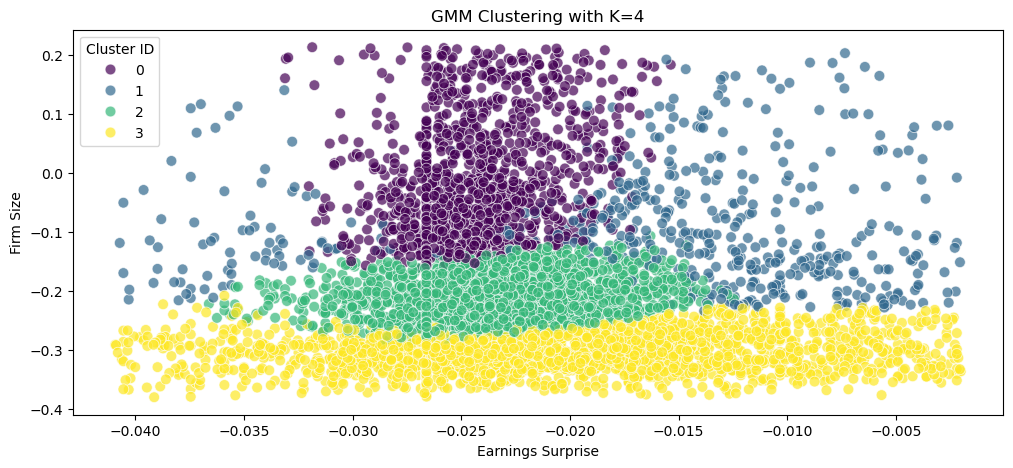

<Figure size 1200x400 with 0 Axes>

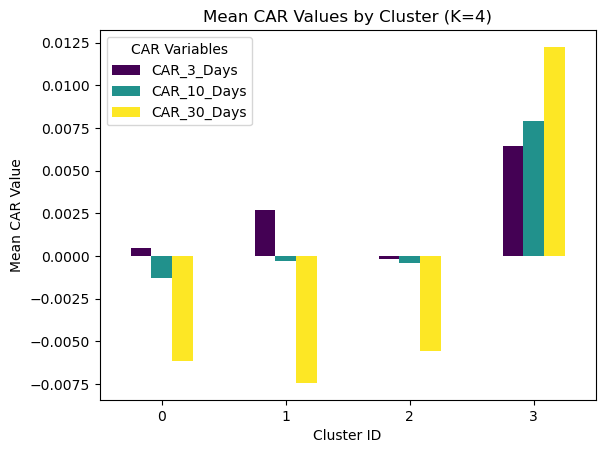

📊 Mean CAR values for K=4:
           CAR_3_Days  CAR_10_Days  CAR_30_Days
Cluster_4                                      
0            0.000500    -0.001258    -0.006137
1            0.002720    -0.000277    -0.007431
2           -0.000183    -0.000435    -0.005539
3            0.006473     0.007928     0.012247
--------------------------------------------------
Silhouette Score for K=5: -0.1608


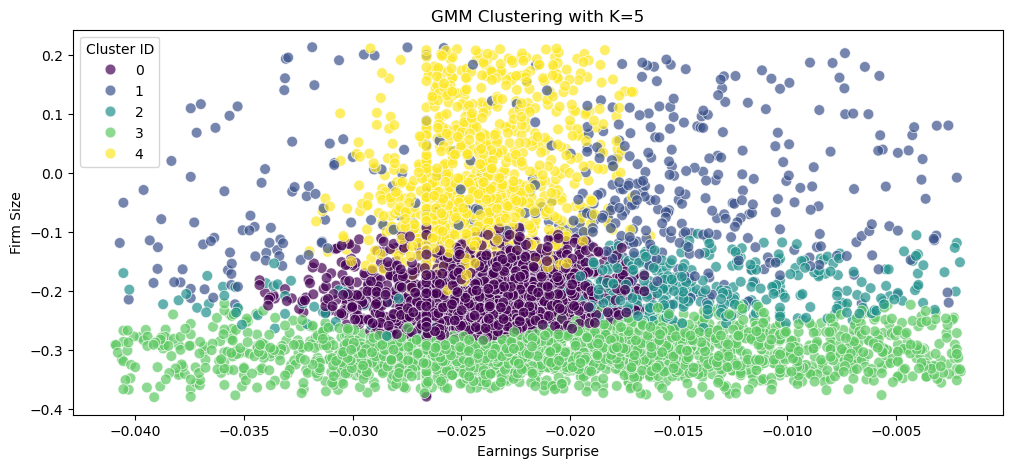

<Figure size 1200x400 with 0 Axes>

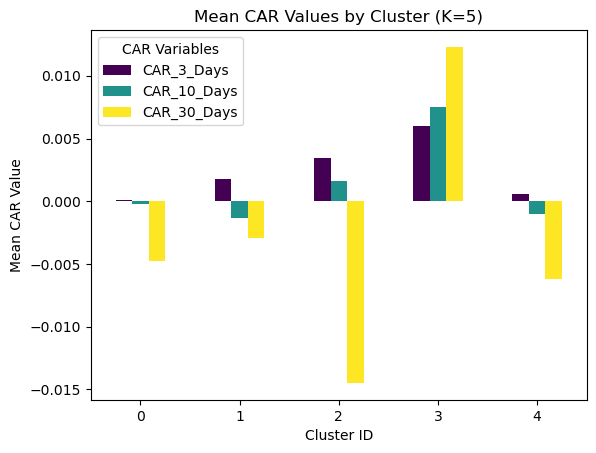

📊 Mean CAR values for K=5:
           CAR_3_Days  CAR_10_Days  CAR_30_Days
Cluster_5                                      
0            0.000097    -0.000206    -0.004752
1            0.001735    -0.001328    -0.002959
2            0.003428     0.001575    -0.014478
3            0.005974     0.007515     0.012298
4            0.000596    -0.001002    -0.006220
--------------------------------------------------
  Earnings_Call_Date  Earnings_Surprise  Firm_Size  method_2  CAR_3_Days  \
0         2020-01-08          -0.015581  -0.208570  1.766057   -0.014271   
1         2020-01-08          -0.023933  -0.338141  0.071589   -0.008348   
2         2020-01-22          -0.009249  -0.339219  0.282063    0.094707   
4         2020-01-23          -0.028122  -0.322995 -1.021321    0.017126   
5         2020-01-24          -0.024730  -0.124929  0.153801   -0.021278   

   CAR_10_Days  CAR_30_Days  Cluster_3  Cluster_4  Cluster_5  
0     0.010221     0.083406          2          2          2  
1  

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Select feature columns for clustering
feature_cols = ["Earnings_Surprise", "Firm_Size", "method_2"]
X = df[feature_cols]

# Define target variables for interpretability check
target_cols = ["CAR_3_Days", "CAR_10_Days", "CAR_30_Days"]

# Try clustering with K=3, K=4, and K=5
k_values = [3, 4, 5]
clustered_dfs = {}

for k in k_values:
    # Fit GMM model
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    df[f"Cluster_{k}"] = gmm.fit_predict(X)  # Assign cluster labels
    clustered_dfs[k] = df.copy()  # Save results

    # Compute silhouette score
    silhouette = silhouette_score(X, df[f"Cluster_{k}"])
    print(f"Silhouette Score for K={k}: {silhouette:.4f}")

    # Scatter plot to visualize clustering
    plt.figure(figsize=(12, 5))
    sns.scatterplot(x=df["Earnings_Surprise"], y=df["Firm_Size"], hue=df[f"Cluster_{k}"], palette="viridis", s=60, alpha=0.7)
    plt.xlabel("Earnings Surprise")
    plt.ylabel("Firm Size")
    plt.title(f"GMM Clustering with K={k}")
    plt.legend(title="Cluster ID")
    plt.show()


    # Bar plots: Mean CAR values for each cluster
    cluster_means = df.groupby(f"Cluster_{k}")[target_cols].mean()

    plt.figure(figsize=(12, 4))
    cluster_means.plot(kind="bar", colormap="viridis")
    plt.xlabel("Cluster ID")
    plt.ylabel("Mean CAR Value")
    plt.title(f"Mean CAR Values by Cluster (K={k})")
    plt.legend(title="CAR Variables")
    plt.xticks(rotation=0)
    plt.show()

    # Print the mean values of CAR variables for each cluster
    print(f"📊 Mean CAR values for K={k}:")
    print(cluster_means)
    print("-" * 50)

print(df.head())


In [257]:
import pandas as pd
import scipy.stats as stats

# Select clustering result (Replace K=3 with your best K)
K = 3  # Change this if you want to test K=4 or K=5
cluster_col = f"Cluster_{K}"

# Define CAR variables
target_cols = ["CAR_3_Days", "CAR_10_Days", "CAR_30_Days"]

# Function to check normality per cluster
def check_normality(df, col):
    p_values = {}
    for cluster in sorted(df[cluster_col].unique()):
        stat, p_value = stats.shapiro(df[df[cluster_col] == cluster][col])
        p_values[cluster] = p_value
    return p_values

# Function to run ANOVA or Kruskal-Wallis based on normality
def run_stat_tests(df):
    for col in target_cols:
        print(f"\n📌 Testing {col} Across Clusters (K={K})")

        # Group data by clusters
        groups = [df[df[cluster_col] == i][col] for i in sorted(df[cluster_col].unique())]

        # Check for normality in each cluster
        normality_pvalues = check_normality(df, col)
        is_normal = all(p > 0.05 for p in normality_pvalues.values())  # p > 0.05 means normal

        print(f"   🔍 Shapiro-Wilk Normality Test (p-values per cluster): {normality_pvalues}")

        if is_normal:
            # Perform One-Way ANOVA (if all clusters are normally distributed)
            f_stat, p_value = stats.f_oneway(*groups)
            print(f"✅ ANOVA Test p-value: {p_value:.4f}")
        else:
            # Perform Kruskal-Wallis test (for non-normal data)
            h_stat, p_value = stats.kruskal(*groups)
            print(f"⚠️ Kruskal-Wallis Test p-value: {p_value:.4f}")

        # Interpretation
        if p_value < 0.05:
            print("🎉 Significant Difference Found! Clustering Meaningfully Separates CAR.")
        else:
            print("❌ No Significant Difference. Clusters Do Not Significantly Affect CAR.")

# Run statistical tests
run_stat_tests(df)



📌 Testing CAR_3_Days Across Clusters (K=3)
   🔍 Shapiro-Wilk Normality Test (p-values per cluster): {0: 3.7632291028378477e-32, 1: 1.5247599981412925e-21, 2: 9.311259303582608e-49}
⚠️ Kruskal-Wallis Test p-value: 0.0958
❌ No Significant Difference. Clusters Do Not Significantly Affect CAR.

📌 Testing CAR_10_Days Across Clusters (K=3)
   🔍 Shapiro-Wilk Normality Test (p-values per cluster): {0: 3.805970448712407e-28, 1: 1.4668341708386984e-19, 2: 4.326910611699071e-39}
⚠️ Kruskal-Wallis Test p-value: 0.0072
🎉 Significant Difference Found! Clustering Meaningfully Separates CAR.

📌 Testing CAR_30_Days Across Clusters (K=3)
   🔍 Shapiro-Wilk Normality Test (p-values per cluster): {0: 9.9568872519319e-21, 1: 4.731756123035951e-10, 2: 1.0071231137304971e-39}
⚠️ Kruskal-Wallis Test p-value: 0.0000
🎉 Significant Difference Found! Clustering Meaningfully Separates CAR.


In [258]:
import pandas as pd
import scipy.stats as stats

# Define CAR variables
target_cols = ["CAR_3_Days", "CAR_10_Days", "CAR_30_Days"]

# Function to check normality per cluster
def check_normality(df, col, cluster_col):
    p_values = {}
    for cluster in sorted(df[cluster_col].unique()):
        stat, p_value = stats.shapiro(df[df[cluster_col] == cluster][col])
        p_values[cluster] = p_value
    return p_values

# Function to run ANOVA or Kruskal-Wallis based on normality
def run_stat_tests(df, K):
    cluster_col = f"Cluster_{K}"
    
    for col in target_cols:
        print(f"\n📌 Testing {col} Across Clusters (K={K})")

        # Group data by clusters
        groups = [df[df[cluster_col] == i][col] for i in sorted(df[cluster_col].unique())]

        # Check for normality in each cluster
        normality_pvalues = check_normality(df, col, cluster_col)
        is_normal = all(p > 0.05 for p in normality_pvalues.values())  # p > 0.05 means normal

        print(f"   🔍 Shapiro-Wilk Normality Test (p-values per cluster): {normality_pvalues}")

        if is_normal:
            # Perform One-Way ANOVA (if all clusters are normally distributed)
            f_stat, p_value = stats.f_oneway(*groups)
            print(f"✅ ANOVA Test p-value: {p_value:.4f}")
        else:
            # Perform Kruskal-Wallis test (for non-normal data)
            h_stat, p_value = stats.kruskal(*groups)
            print(f"⚠️ Kruskal-Wallis Test p-value: {p_value:.4f}")

        # Interpretation
        if p_value < 0.05:
            print("🎉 Significant Difference Found! Clustering Meaningfully Separates CAR.")
        else:
            print("❌ No Significant Difference. Clusters Do Not Significantly Affect CAR.")

# Run statistical tests for K=4 and K=5
for K in [3, 4, 5]:
    run_stat_tests(df, K)



📌 Testing CAR_3_Days Across Clusters (K=3)
   🔍 Shapiro-Wilk Normality Test (p-values per cluster): {0: 3.7632291028378477e-32, 1: 1.5247599981412925e-21, 2: 9.311259303582608e-49}
⚠️ Kruskal-Wallis Test p-value: 0.0958
❌ No Significant Difference. Clusters Do Not Significantly Affect CAR.

📌 Testing CAR_10_Days Across Clusters (K=3)
   🔍 Shapiro-Wilk Normality Test (p-values per cluster): {0: 3.805970448712407e-28, 1: 1.4668341708386984e-19, 2: 4.326910611699071e-39}
⚠️ Kruskal-Wallis Test p-value: 0.0072
🎉 Significant Difference Found! Clustering Meaningfully Separates CAR.

📌 Testing CAR_30_Days Across Clusters (K=3)
   🔍 Shapiro-Wilk Normality Test (p-values per cluster): {0: 9.9568872519319e-21, 1: 4.731756123035951e-10, 2: 1.0071231137304971e-39}
⚠️ Kruskal-Wallis Test p-value: 0.0000
🎉 Significant Difference Found! Clustering Meaningfully Separates CAR.

📌 Testing CAR_3_Days Across Clusters (K=4)
   🔍 Shapiro-Wilk Normality Test (p-values per cluster): {0: 1.4580958650240634e-2

In [259]:
df = df.drop(columns=["Cluster_3", "Cluster_5"])

mapping = {0: "Bearish", 1: "Neutral", 2: "Bearish", 3: "Bullish"}
df["Category"] = df["Cluster_4"].map(mapping)

df = df.drop(columns=["Cluster_4"])

df.head()

,Earnings_Call_Date,Earnings_Surprise,Firm_Size,method_2,CAR_3_Days,CAR_10_Days,CAR_30_Days,Category
0,2020-01-08,-0.015581,-0.208570,1.766057,-0.014271,0.010221,0.083406,Bearish
1,2020-01-08,-0.023933,-0.338141,0.071589,-0.008348,-0.026677,-0.059266,Bullish
2,2020-01-22,-0.009249,-0.339219,0.282063,0.094707,0.089449,0.049796,Bullish
4,2020-01-23,-0.028122,-0.322995,-1.021321,0.017126,0.026210,-0.054972,Bullish
5,2020-01-24,-0.024730,-0.124929,0.153801,-0.021278,0.016655,-0.013365,Bearish


In [260]:

# Set index and ensure it's sorted before using .update()
df.set_index(target_cols, inplace=True)
df.sort_index(inplace=True)  

df_original.set_index(target_cols, inplace=True)
df_original.sort_index(inplace=True)  

# Performing the update
df.update(df_original[feature_cols])

# Reset index
df.reset_index(inplace=True)

# Ensure "Earnings_Call_Date" is in datetime format
df["Earnings_Call_Date"] = pd.to_datetime(df["Earnings_Call_Date"], errors="coerce")

# Extract the year
df["Year"] = df["Earnings_Call_Date"].dt.year

# Count the number of instances per year
yearly_counts = df["Year"].value_counts().sort_index()

# Count instances per category (Bullish, Bearish, Neutral)
category_counts = df["Category"].value_counts()

# Display total yearly and category counts
print("\nInstances per Year:\n", yearly_counts.to_string())
print("\nInstances per Category:\n", category_counts.to_string())

df_original.head()
df.head()

# Count instances per year for each category
yearly_category_counts = df.groupby(["Year", "Category"]).size().unstack(fill_value=0)

# Print breakdown for each year
print("\nYearly Breakdown of Categories:\n", yearly_category_counts.to_string())

# Split into training and test datasets
train_data = df[df["Year"] != 2024].copy()  # Ensure copy to prevent SettingWithCopyWarning
test_data = df[df["Year"] == 2024].copy()

# Drop the "Year" column from both datasets
train_data.drop(columns=["Year"], inplace=True)
test_data.drop(columns=["Year"], inplace=True)

# Save the training and test datasets
train_data.to_csv("training_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

print("\nTraining data saved to training_data.csv")
print("Test data (2024) saved to test_data.csv")



Instances per Year:
 Year
2020     861
2021    1192
2022    1331
2023    1370
2024    1284

Instances per Category:
 Category
Bearish    3065
Bullish    2478
Neutral     495

Yearly Breakdown of Categories:
 Category  Bearish  Bullish  Neutral
Year                               
2020          311      463       87
2021          598      486      108
2022          693      540       98
2023          730      541       99
2024          733      448      103

Training data saved to training_data.csv
Test data (2024) saved to test_data.csv
